## Travelling salesman

Code to try and find a solution to the travelling salesman problem on the globe using object-oriented simulated annealing


Name: Peter Breslin  
Student ID: 17340915

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random

import csv
import smopy

#smopy tile server and basic options
smopy.TILE_SERVER = "http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}@2x.png"
smopy.TILE_SIZE = 512

ppl = 100

worldmap = smopy.Map((0, -120, 65, 120), z=2)
ie_map = smopy.Map((51.0, -10.9, 55.5, -5.0), z=7)

In [40]:
class SalesmanAnneal:
    '''Solves the TSM problem using a simulated annealing approach'''
    
    def __init__(self, lats, lons, cities, basemap, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        '''initialise the solver, loads city coordinates/names from arguments '''
        self.cities = cities
        self.lats=lats
        self.lons=lons
        self.N = len(cities)
        self.basemap =basemap
        
        self.initial_route = np.random.permutation(np.arange(self.N))
        self.currentgrid=np.copy(self.initial_route)
        self.bestgrid=np.copy(self.initial_route)
        self.fitnesslist=[]
        self.cur_fitness = self.fitness(self.currentgrid)
        self.initial_fitness = self.cur_fitness
        self.best_fitness = self.cur_fitness
        self.fitness_list = [self.cur_fitness]
        
        self.T = 1.0E6 if T == -1 else T
        self.alpha = 0.9994 if alpha == -1 else alpha
        self.stopping_temperature = 0.00001 if stopping_T == -1 else stopping_T
        self.stopping_iter = 30000 if stopping_iter == -1 else stopping_iter
        self.iteration = 1
        
    def fitness(self, route):
        H=0
        c=0
        '''returns the "fitness", i.e. total RETURN path length.'''
        for i in range(self.N):
            for j in range(self.N):
                if j%self.N-i%self.N==1:
                    c=1
                    H += c*self.gcd(route[i],route[j])
        return H
                
    
    
    def anneal(self):
        '''simulated annealing to find solution'''
        self.currentroute=self.initial_route
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:
            bi,bj=random.randint(0,self.N),random.randint(0,self.N)
            candidate = np.copy(self.currentgrid)
            candidate[bi],candidate[bj]=candidate[bj],candidate[bi]
            self.accept(candidate)
            self.T *= self.alpha
            self.iteration += 1
            
            # add current fitness to list
            self.fitness_list.append(self.cur_fitness)
        self.print_route(self.bestgrid)
        x=self.fitness_list
        plt.figure(3)
        plt.title('Simulated Annealing')
        plt.xlabel('Iteration Number')
        plt.ylabel("Path Length")
        plt.plot(x)
        plt.show()
        
            
    
    def accept(self, candidate):
        '''sets the acceptance rules for a new candidate'''
        candidate_fitness = self.fitness(candidate)
        
        # probability 1 for a lower energy candidate
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness = candidate_fitness
            self.currentgrid = candidate
            
            #is the new candidate the best so far?
            if candidate_fitness < self.best_fitness:
                self.best_fitness = candidate_fitness
                self.bestgrid = candidate
                
        # otherwise accept with a probability given by the boltzmann-like term
        else:
            if np.random.random() < np.exp( - abs( candidate_fitness -self.cur_fitness) / self.T):
                self.cur_fitness = candidate_fitness
                self.currentgrid = candidate
                
                
    def print_route(self, route):
        '''Outputs a pretty map showing a particular route'''
        
        #base map to print our route on
        fig, ax = plt.subplots(figsize=(8, 5))
        ax = plt.subplot(111)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax.set_xlim(0, self.basemap.w)
        ax.set_ylim(self.basemap.h, 0)
        ax.axis('off')
        plt.tight_layout()
        ax.imshow(self.basemap.img)
        
        #cities
        px, py = [], []
        for i in range(self.N):
            plotx, ploty = self.basemap.to_pixels(self.lats[i], 
                                                 self.lons[i])
            px.append(plotx)
            py.append(ploty)
            
        
        ax.plot(px, py, 'or')
        
        #include labels
        [ax.annotate(self.cities[i], xy=(px[i], py[i]), 
                     xytext=(px[i]+1, py[i]), color='k', size=8) 
         for i in range(0, self.N)]
        gcd_trip = [ self.gcd_path(route[i-1], route[i], ppl) 
                    for i in range(1, self.N) 
                   ] + [self.gcd_path(route[self.N-1], route[0], ppl)]
        
        px1, py1 = [], []
        for leg_lat, leg_lon in gcd_trip:
            for pt in np.arange(len(leg_lat)):
                plotx, ploty = self.basemap.to_pixels(leg_lat[pt], 
                                                      leg_lon[pt])
                px1.append(plotx)
                py1.append(ploty)
                
                
        ax.plot(px1, py1, 'or', ms=0.3)
        #plt.xlim(480,500)
        #plt.ylim(340,320)
        
        return fig, ax
        
               
    #other methods (e.g. GCD between two points, path route....)
    # The length of the shortest path between a and b
    def gcd(self, a, b):
        lat1 = np.radians(self.lats[a])
        lat2 = np.radians(self.lats[b])
        lon1 = np.radians(self.lons[a])
        lon2 = np.radians(self.lons[b])

        dlon = lon2 - lon1 
        dlat = lat2 - lat1 

        hav = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2 
        c = 2 * np.arctan2( np.sqrt(hav), np.sqrt(1-hav) ) 
        return 6371* c 


# A function that returns "num" points on the shortest path between a and b
    def gcd_path(self, a, b, num):
        lat1 = np.radians(self.lats[a])
        lat2 = np.radians(self.lats[b])
        lon1 = np.radians(self.lons[a])
        lon2 = np.radians(self.lons[b])

        d=self.gcd(a, b)
        f= np.linspace(0, 1, num)

        delta = d / 6371
        alpha = np.sin((1-f)*delta) / np.sin(delta)
        beta = np.sin(f*delta) / np.sin(delta)

        x = alpha * np.cos(lat1) * np.cos(lon1) + beta * np.cos(lat2) * np.cos(lon2)
        y = alpha * np.cos(lat1) * np.sin(lon1) + beta * np.cos(lat2) * np.sin(lon2)
        z = alpha * np.sin(lat1) + beta * np.sin(lat2)

        newlats = (np.arctan2(z, np.sqrt(x**2 + y**2)))
        newlons = (np.arctan2(y, x))
        return np.degrees(newlats), (np.degrees(newlons) +540)%360 -180

In [41]:
## Full lists of cities
total_names, total_lats, total_lons, total_pop, total_countries =[],[],[],[],[]

# Open CSV file, scan line-by-line and populate lists
with open('simplemaps-worldcities-basic(1).csv', encoding="utf8") as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    
    #skip the first line, which contains the legend
    next(readCSV)
    
    #add elements row-wise
    for row in readCSV:
        city = row[1]
        lat = float(row[2])
        lon = float(row[3])
        pop = int(float((row[4])))
        
        total_names.append(city)
        total_lats.append(lat)
        total_lons.append(lon)
        total_pop.append(pop) 

### Exercise 1: Optimal distance between 30 random cities from the list

In [46]:
path_length = 30
path_indices = np.random.choice ( np.arange( len(total_names) ), 
                                            path_length, 
                                            replace=False    )
path_names = [total_names[i] for i in path_indices]
path_lats = [total_lats[i] for i in path_indices]
path_lons = [total_lons[i] for i in path_indices]

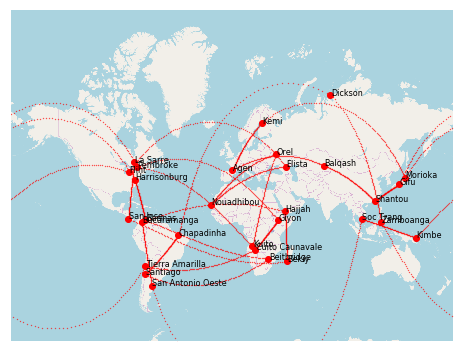

In [47]:
random_solution=SalesmanAnneal(path_lats, path_lons, path_names, worldmap)
fig, ax = random_solution.print_route(random_solution.initial_route)
plt.show()
fig.savefig('random_30.png', bbox_inches='tight', dpi=200)

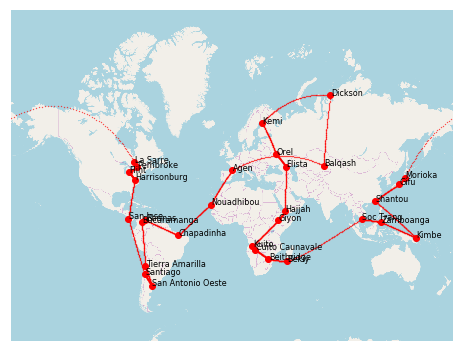

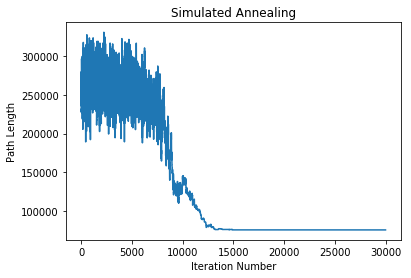

AttributeError: 'NoneType' object has no attribute 'savefig'

In [55]:
random_solution.anneal()
#fig1.savefig('random_solution_anneal.png', bbox_inches='tight', dpi=200)

### Exercise 2: Optimal distance between the 25 most populous cities on the list


In [49]:
# Sort lists by population with largest first
sorting = np.argsort(total_pop)[::-1]
city_sort, pop_sort, lat_sort, lon_sort = np.array(total_names)[sorting], np.array(total_pop)[sorting], np.array(total_lats)[sorting], np.array(total_lons)[sorting]
#popsort = np.array(population)[sorting]
print(city_sort)

['Tokyo' 'Mumbai' 'Mexico City' ..., 'Nordvik' 'Fortin Falcon' 'Kavache']


In [50]:
total_lats, total_lons, total_names, total_pop = [],[],[],[]

In [51]:
for city, pop, lat, lon in zip(city_sort, pop_sort, lat_sort, lon_sort):
    #random_solution=SalesmanAnneal(path_lats, path_lons, path_names, worldmap )
    #fig, ax = random_solution.print_route(random_solution.initial_route)

    total_names.append(city)
    total_lats.append(lat)
    total_lons.append(lon)
    total_pop.append(pop) 
    
    print('%-18s %8i %8i %8i' % (city, pop, lat, lon) )

#print(pop_names)

Tokyo              22006299       35      139
Mumbai             15834918       19       72
Mexico City        14919501       19      -99
Shanghai           14797756       31      121
Sao Paulo          14433147      -23      -46
New York           13524139       40      -73
Karachi            11877109       24       66
Buenos Aires       11862073      -34      -58
Delhi              11779606       28       77
Moscow             10452000       55       37
Istanbul           10003305       41       29
Dhaka               9899167       23       90
Cairo               9813807       30       31
Seoul               9796000       37      126
Kolkata             9709196       22       88
Beijing             9293300       39      116
Jakarta             8832560       -6      106
Los Angeles         8097410       33     -118
London              7994104       51        0
Tehran              7513154       35       51
Lima                7385117      -12      -77
Manila              7088787       

Banja Luka           221422       44       17
Chon Buri            221340       13      100
Neyshabur            221314       36       58
Groznyy              221237       43       45
Hailar               221118       49      119
Saint-Etienne        220982       45        4
El Fasher            220906       13       25
Yakutsk              220813       62      129
Butembo              220512        0       29
Novi Sad             220428       45       19
Al Khalil            220395       31       35
Cabanatuan           220250       15      120
Sterlitamak          220040       53       55
Myeik                220009       12       98
Miri                 219957        4      113
Thanjavur            219571       10       79
Nagercoil            219093        8       77
Hami                 218960       42       93
Velikiy Novgorod     218717       58       31
Wuhai                218427       39      106
Bandar Seri Begawan   218250        4      114
Chuncheon            218127      

Pirapora              55910      -17      -44
Lautoka               55894      -17      177
Bani Walid            55871       31       13
Kentau                55864       43       68
Gualeguaychu          55860      -33      -58
Jabal Ali             55817       24       55
Manacapuru            55780       -3      -60
Texas City            55717       29      -94
Parachinar            55685       33       70
Civitavecchia         55674       42       11
Evora                 55620       38       -7
Arras                 55608       50        2
Fernandopolis         55587      -20      -50
Springfield           55531       44     -122
Lake Havasu City      55442       34     -114
Milagro               55433       -2      -79
Halmstad              55433       56       12
Itapeva               55324      -23      -48
Zarafshon             55292       41       64
San Pedro             55249      -24      -64
Khujayli              55200       42       59
Chaiyaphum            55191       

Obando                 8181        3      -67
Katherine              8171      -14      132
Muswellbrook           8171      -32      150
Santa Cruz             8147        0      -90
Ndalatando             8144       -9       14
Shannon                8143       52       -8
Dalnegorsk             8123       44      135
Bethanie               8122      -26       17
Ketchikan              8121       55     -131
Putina                 8118      -15      -69
Socorro                8117       34     -106
Halacho                8116       20      -90
Sitka                  8110       57     -135
Masindi-Port           8073        1       32
Magdagachi             8070       53      125
Puerto Aisen           8067      -45      -72
Pokrovsk               8065       61      129
Moree                  8062      -29      149
Uliastay               8056       47       96
Puerto Carreno         8038        6      -67
McCook                 8003       40     -100
Powell River           7999       

In [52]:
path_length = 25
path_indices = np.arange(0,path_length,1)
path_names = [total_names[i] for i in path_indices]
path_lats = [total_lats[i] for i in path_indices]
path_lons = [total_lons[i] for i in path_indices]

#path_population = [popsort[i] for i in path_indices_pop]


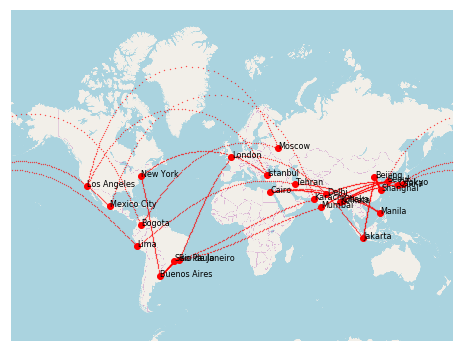

In [53]:
largest_pop = SalesmanAnneal(path_lats, path_lons, path_names, worldmap )
fig, ax = largest_pop.print_route(largest_pop.initial_route)
plt.show()
fig.savefig('highest_pop.png', bbox_inches='tight', dpi=200)

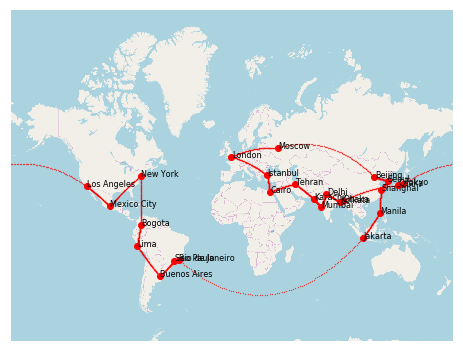

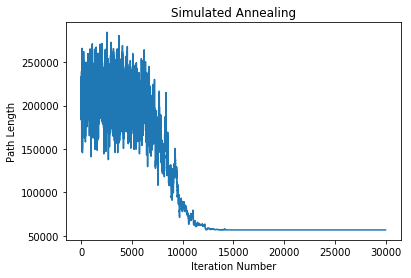

In [54]:
fig2 = largest_pop.anneal()
#fig2.savefig('highest_pop_anneal.png', bbox_inches='tight', dpi=200)

### Exercise 3: Optimal Distance between all the Irish cities on the list

In [56]:
ie_names, ie_lats, ie_lons, ie_pops, ie_countries =[], [], [], [], []

with open('simplemaps-worldcities-basic(1).csv', encoding="utf8") as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    
    #skip the first line, which contains the legend
    next(readCSV)
    
    #add elements row-wise
    for row in readCSV:
        city = row[1]
        lat = float(row[2])
        lon = float(row[3])
        pop = int(float((row[4])))  # rounding populations with .5s
        country = row[5]
        
        if(country == 'Ireland') or (city == 'Belfast'):
            ie_names.append(city)
            ie_lats.append(lat)
            ie_lons.append(lon)
            ie_pops.append(pop)  
            
print(ie_names)

['Ros Comain', 'Muineachan', 'Shannon', 'Waterford', 'Tralee', 'Donegal', 'Drogheda', 'Dundalk', 'Galway', 'Kilkenny', 'Killarney', 'Sligo', 'Cork', 'Limerick', 'Dublin', 'Belfast']


In [57]:
path_length = len(ie_names)
path_indices = np.arange(0,path_length,1)
path_names = [ie_names[i] for i in path_indices]
path_lats = [ie_lats[i] for i in path_indices]
path_lons = [ie_lons[i] for i in path_indices]

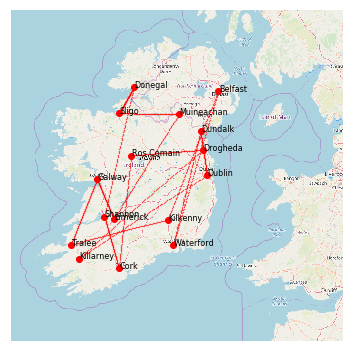

In [58]:
ie_cities = SalesmanAnneal(path_lats, path_lons, path_names, ie_map )
fig, ax = ie_cities.print_route(ie_cities.initial_route)
plt.show()
fig.savefig('irish_cities.png', bbox_inches='tight', dpi=200)

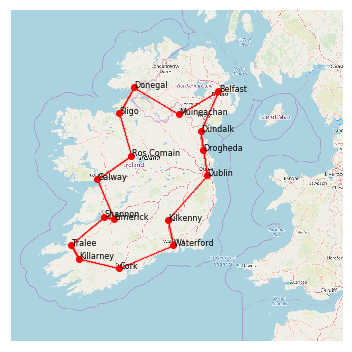

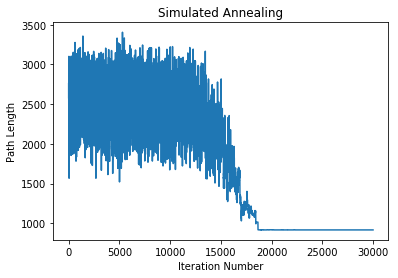

In [59]:
ie_cities.anneal()
#fig.savefig('ie_cities_anneal.png', bbox_inches='tight', dpi=200)